## Stable Moving CA

### Imports

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from tqdm import tqdm

import IPython
from IPython.display import display, HTML

In [48]:
#device = torch.device('mps:0' if torch.backends.mps.is_available else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


### Model

In [83]:
class CA(nn.Module):
    def __init__(self):
        super(CA, self).__init__()
        #self.conv1 = nn.Conv2d(2, 8, 3, padding=1)
        self.conv1 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, 1, padding=0)
        #self.conv3 = nn.Conv2d(8, 2, 1, padding=0)
        self.conv3 = nn.Conv2d(8, 4, 1, padding=0)
        with torch.no_grad():
            self.conv3.weight.zero_() #todo should this be done for this, none or all of them?
        self.alive = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

    def alive_filter(self, x):
        #return self.alive(x[:, 3:4, :, :]) > 0.1 #need to have any cell within kernel size be alive 
        return self.alive(x) > 0.1 #need to have any cell within kernel size be alive 

    def perceive(self, x):
        return torch.relu(self.conv1(x))

    def update(self, x):
        #x = x.transpose(0, 2)
        pre_life_mask = self.alive_filter(x)
        #x = x.transpose(0, 2)
        z = self.perceive(x)
        #z = z.transpose(0, 2)
        z = torch.relu(self.conv2(z))
        z = self.conv3(z)

        #z = z.transpose(0, 2)
        post_life_mask = self.alive_filter(z)
        life_mask = torch.bitwise_and(pre_life_mask, post_life_mask).to(torch.float)
        z = z * life_mask #mask
        #return z.transpose(0, 2)
        return z

    def forward(self, x, steps):
        for _ in range(steps):
            #could reset cell state here, but that will invalidate all of its functionality...
            x = self.update(x)
        return x

### Training
Food needs to be reapplied to smell each epoch - especially in case more food is added

Though existing smell need to be persistent but maybe a bit degrading each epoch

In [117]:
def get_random_state():
    mat = torch.zeros(16, 16, device=device)
    #mat = torch.zeros(32, 32, 8, device=device)
    mat2 = torch.rand(5,5, device=device) > 0.7

    #mat[14:19,14:19] = mat2
    mat[6:11,6:11] = mat2
    zeros = torch.zeros_like(mat, device=device)
    state = torch.stack([mat, zeros, zeros, zeros])
    return state

def train(model, iterations, optimizer, criterion, epochs=1):
    losses = np.zeros(iterations * epochs // 10)
    for epoch in tqdm(range(epochs)):
        for i in range(iterations):
            if i % 4000 == 0:
                state = get_random_state()
            #input_alive_count = torch.count_nonzero(torch.where(state > 0.1, state, 0)).type(torch.float32)
            #could use this to mask out all except the top n cells

            optimizer.zero_grad()
            if epoch < 5:
                state_hat = model(state, epoch+1)
            else:
                state_hat = model(state, 50)

            loss = criterion(state_hat[0], state[0])

            if i % 10 == 0: 
                losses[epoch*iterations//10 + i//10] = loss.item()
            loss.backward()
            optimizer.step()
        print(loss)
    return model, losses

### Main

In [124]:
#initial state
model = CA().to(device)
iterations = 10000
epochs = 6
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
model, losses = train(model, iterations, optimizer, criterion, epochs)

 17%|█▋        | 1/6 [00:16<01:22, 16.42s/it]

tensor(1.0139e-15, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 2/6 [00:40<01:22, 20.70s/it]

tensor(3.6398e-09, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|█████     | 3/6 [01:10<01:15, 25.16s/it]

tensor(7.7490e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 4/6 [01:48<01:00, 30.33s/it]

tensor(5.7853e-16, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 5/6 [02:30<00:34, 34.50s/it]

tensor(5.8350e-09, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 6/6 [03:18<00:00, 33.06s/it]

tensor(5.1344e-08, device='cuda:0', grad_fn=<MseLossBackward0>)


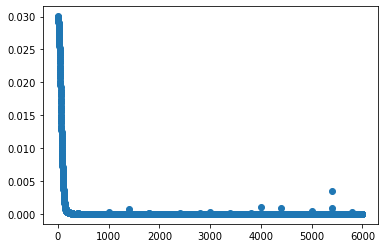

In [126]:
fig, ax = plt.subplots()

losses1 = [[i, value] for i, value in enumerate(losses)]
losses1 = np.array(losses1)

losses2 = losses1[:,1]
#ax.plot(losses)
ax.scatter(losses1[:, 0], losses2)
#ax.set_yscale('logit')
#ax.set_ylim([0.0000000001,0.001])

plt.show()

[3.20866667e-02 3.20081078e-02 3.19275074e-02 ... 4.20427887e-10
 4.19930285e-10 4.19289214e-10]
2.1303404737450804


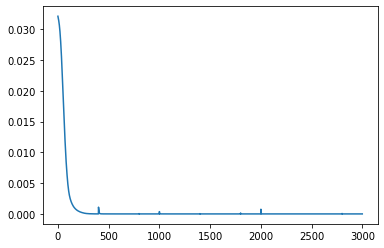

In [96]:
print(losses)
plt.plot(losses)
print(np.sum(losses))

In [127]:
#save progress
torch.save(model.state_dict(), 'models/model_ca_11.pth')

### Test - Animate

In [24]:
#model = CA()
#model.load_state_dict(torch.load('models/model_ca_3.pth'))
#model = model.to(device)

In [131]:
#Setup
state = get_random_state()
state = state.float().unsqueeze(0).to(device)
print(state.shape)

torch.Size([1, 4, 16, 16])


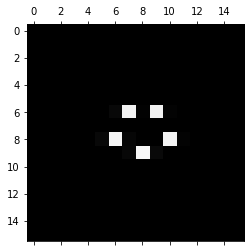

In [133]:
#iterate
@torch.no_grad()
def animate(i):
    global state
    #state = torch.softmax(model(state), dim=1).to(device) #calculate new state
    state = model(state, 1) #calculate new state
    mat.set_data(state.detach().cpu().numpy()[0,0]) #update the mat shown to reflect the new state

fig, ax = plt.subplots()
mat = ax.matshow(state.detach().cpu().numpy()[0,0], cmap="gray") #show mat in fig

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=100).to_jshtml())

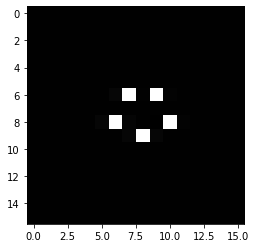

In [132]:
state1 = state
state1 = model(state1, 1)
#plt.imshow(state1.reshape(2, 32,32).cpu().detach().numpy()[0], cmap='gray')
plt.imshow(state1.reshape(4, 16, 16).cpu().detach().numpy()[0], cmap='gray')

In [28]:
print(model)

CA(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
  (alive): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
)


In [29]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[[[-0.0026,  0.2328, -0.0069],
          [ 0.2188,  0.6871,  0.0978],
          [ 0.0530,  0.0722,  0.2076]],

         [[ 0.2195,  0.1863, -0.1623],
          [ 0.1279, -0.0483, -0.0928],
          [ 0.1773,  0.0369,  0.1197]]],


        [[[ 0.0700,  0.1568,  0.0643],
          [ 0.0619, -0.1508,  0.1239],
          [ 0.0313,  0.1613,  0.2746]],

         [[-0.2156,  0.0443,  0.1148],
          [ 0.2166,  0.1494, -0.2156],
          [ 0.1964,  0.1265, -0.1172]]],


        [[[ 0.0120,  0.1931, -0.0818],
          [ 0.0597, -0.2306,  0.1422],
          [ 0.1282,  0.0144,  0.0100]],

         [[-0.1583,  0.1566, -0.1142],
          [-0.1376, -0.0672,  0.0788],
          [ 0.1101, -0.1461,  0.1005]]],


        [[[ 0.1847,  0.1254,  0.2471],
          [ 0.3576, -0.0901,  0.1760],
          [ 0.2535,  0.2501,  0.2870]],

         [[-0.0938, -0.0556,  0.0821],
          [-0.0216,  0.2091,  0.1880],
          [ 0.1060, -0.1626, -0.1550]]],


        [[[ 0.0245

In [30]:
print(torch.sum(state1))

tensor(4.3141, device='cuda:0', grad_fn=<SumBackward0>)
